In [15]:
from tensorflow import keras
from tensorflow.keras import layers

In [16]:
input_img = keras.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(
                filters=10,
                kernel_size=3,
                strides=(2, 2),
                padding="valid",
                activation="relu",
            )(input_img)
x = layers.Conv2D(
                filters=20,
                kernel_size=3,
                strides=(2, 2),
                padding="valid",
                activation="relu",
            )(x)
x = layers.Conv2D(
                filters=40,
                kernel_size=3,
                strides=(2, 2),
                padding="valid",
                activation="relu",
            )(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
encoded = layers.Dense(20)(x)

# Decoder
decoder_input = layers.InputLayer(input_shape=20)(encoded)
x = layers.Dense(128, activation="relu")(decoder_input)
x = layers.Dense(7*7*32, activation="relu")(x)
x = layers.Reshape((7, 7, 32))(x)
x = layers.Conv2DTranspose(
                filters=40, kernel_size=3, strides=2, padding="same", activation="relu"
            )(x)
x = layers.Conv2DTranspose(
                filters=20, kernel_size=3, strides=2, padding="same", activation="relu"
            )(x)
decoded = layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding="same", activation="sigmoid")(x)


autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.save_weights('initial_model.h5')
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 13, 13, 10)        100       
                                                                 
 conv2d_13 (Conv2D)          (None, 6, 6, 20)          1820      
                                                                 
 conv2d_14 (Conv2D)          (None, 2, 2, 40)          7240      
                                                                 
 flatten_4 (Flatten)         (None, 160)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               20608     
                                                                 
 dense_13 (Dense)            (None, 20)                2580

In [14]:
from stacked_mnist import StackedMNISTData, DataMode
import numpy as np

generator = StackedMNISTData(mode=DataMode.MONO_BINARY_COMPLETE, default_batch_size=2048)

x_train, y_train = generator.get_full_data_set(training=True)
x_test, y_test = generator.get_full_data_set(training=False)

# "Translate": Only look at "red" channel; only use the last digit. Use one-hot for labels during training
x_train = x_train[:, :, :, [0]]
y_train = keras.utils.to_categorical((y_train % 10).astype(np.int), 10)
x_test = x_test[:, :, :, [0]]
y_test = keras.utils.to_categorical((y_test % 10).astype(np.int), 10)

/var/folders/w2/4g3c4yrn38g2nwwdhjdlx6fc0000gn/T/ipykernel_2878/4188248072.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_train = keras.utils.to_categorical((y_train % 10).astype(np.int), 10)
/var/folders/w2/4g3c4yrn38g2nwwdhjdlx6fc0000gn/T/ipykernel_2878/4188248072.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precisi

In [5]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
469/469 [==============================] - 33s 69ms/step - loss: 0.1732 - val_loss: 0.0851
Epoch 2/10
469/469 [==============================] - 32s 68ms/step - loss: 0.0742 - val_loss: 0.0646
Epoch 3/10
469/469 [==============================] - 33s 70ms/step - loss: 0.0617 - val_loss: 0.0572
Epoch 4/10
469/469 [==============================] - 33s 70ms/step - loss: 0.0563 - val_loss: 0.0543
Epoch 5/10
469/469 [==============================] - 31s 67ms/step - loss: 0.0531 - val_loss: 0.0516
Epoch 6/10
469/469 [==============================] - 34s 72ms/step - loss: 0.0509 - val_loss: 0.0503
Epoch 7/10
469/469 [==============================] - 34s 73ms/step - loss: 0.0493 - val_loss: 0.0492
Epoch 8/10
469/469 [==============================] - 33s 71ms/step - loss: 0.0480 - val_loss: 0.0477
Epoch 9/10
469/469 [==============================] - 33s 69ms/step - loss: 0.0470 - val_loss: 0.0465
Epoch 10/10
469/469 [==============================] - 39s 83ms/step - loss: 0.046

In [6]:
from verification_net import VerificationNet

net = VerificationNet(force_learn=False, file_name="../models/verification_model")
img, labels = generator.get_random_batch(training=False, batch_size=25000)
decoded_imgs = autoencoder.predict(img)
_, acc_ae = net.check_predictability(data=decoded_imgs, correct_labels=labels)
_, acc_orig = net.check_predictability(data=img, correct_labels=labels)
print(f"Accuracy of Reconstruction: {100 * acc_ae:.2f}%")

Accuracy of Reconstruction: 92.87%


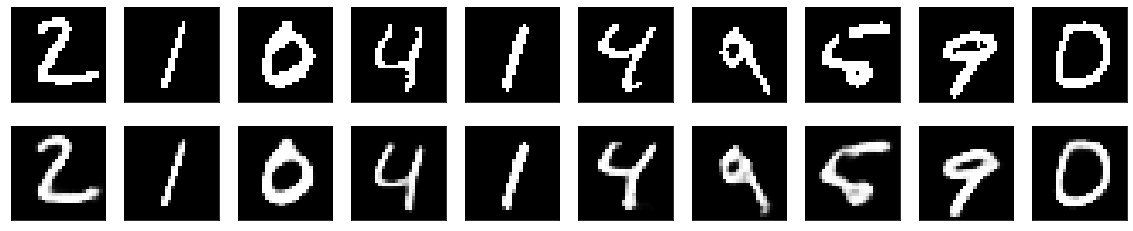

In [7]:
import matplotlib.pyplot as plt
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

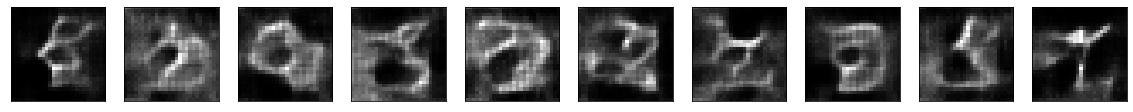

In [8]:
import numpy as np

z = np.random.randn(100, 20)

decoder = keras.Model(decoder_input, decoded)
decoded_z = decoder.predict(z)
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(decoded_z[i-1].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [12]:
generated = decoder.predict(np.random.randn(2000, 20))
cov = net.check_class_coverage(data=generated, tolerance=0.98)
pred, _ = net.check_predictability(data=generated)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")

Coverage: 10.00%
Predictability: 50.00%
